In [1]:
pip install psx-data-reader

Note: you may need to restart the kernel to use updated packages.


## Fetching Stock Data

We use the `psx` library to retrieve stock data for "APL" from 2020 to 2023.

In [33]:
from psx import stocks, tickers
import pandas as pd
import numpy as np
import datetime

tickers = tickers()

data = stocks("APL", start=datetime.date(2020, 1, 1), end=datetime.date(2023, 12, 31))

## Data Preprocessing

We reset the index of the `data_df` DataFrame, drop the "Volume" column, and print the resulting length.

In [34]:
data_df = pd.DataFrame(data)

In [35]:
df = data_df.reset_index()
df = df.drop("Volume", axis=1)
print(len(df))

991


In [36]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Date,Open,High,Low,Close
0,2020-01-01,370.25,373.90,365.25,367.66
1,2020-01-02,370.00,375.90,369.75,371.03
2,2020-01-03,374.99,384.00,368.00,374.73
3,2020-01-06,365.00,369.99,364.50,365.34
4,2020-01-07,370.00,374.99,369.00,370.78


## Visualizing Mid-Price Over Time

We generate a plot to visualize the mid-price (average of 'Low' and 'High') of the stock over time.

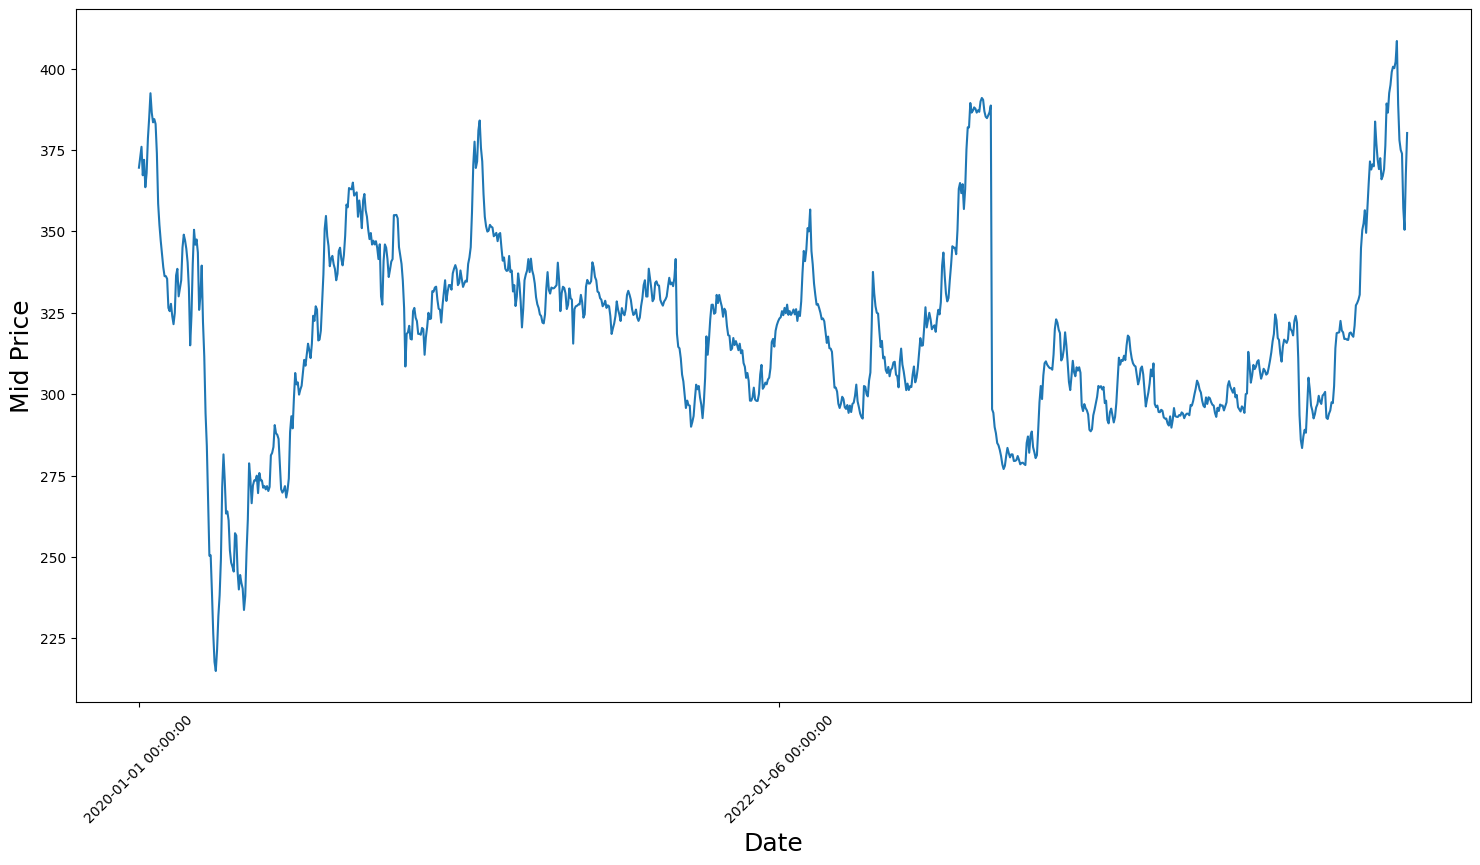

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

## Calculating Mid-Prices and Splitting Data

We calculate the mid-prices by averaging the 'High' and 'Low' prices.

In [38]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:, 'High'].to_numpy()
low_prices = df.loc[:, 'Low'].to_numpy()
mid_prices = (high_prices + low_prices) / 2.0

# Split into training and test data
train_data = mid_prices[:801]
test_data = mid_prices[801:]

## Scaling Data using MinMaxScaler

We use `MinMaxScaler` from scikit-learn to scale the training and test data between 0 and 1. It's crucial to fit the scaler only on the training data to avoid data leakage.


In [39]:
from sklearn.preprocessing import MinMaxScaler

# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

print(train_data.shape)

(801, 1)


In [40]:
model=scaler.fit(train_data)
scaled_data=model.transform(train_data)

In [41]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

## Exponential Moving Average Smoothing and Simple Moving Average Prediction

First, we apply exponential moving average (EMA) smoothing to the training data to reduce noise. Next, we concatenate the smoothed training data with the test data for visualization purposes.

In [42]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(490):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

Then, we implement a simple moving average (SMA) prediction using a window size of 5. We calculate the mean squared error (MSE) between the predictions and the actual training data.

In [43]:
window_size = 5
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 44.06878


Finally, we plot the actual mid-prices and the SMA predictions. This visualization allows us to compare the predicted mid-prices with the actual values.

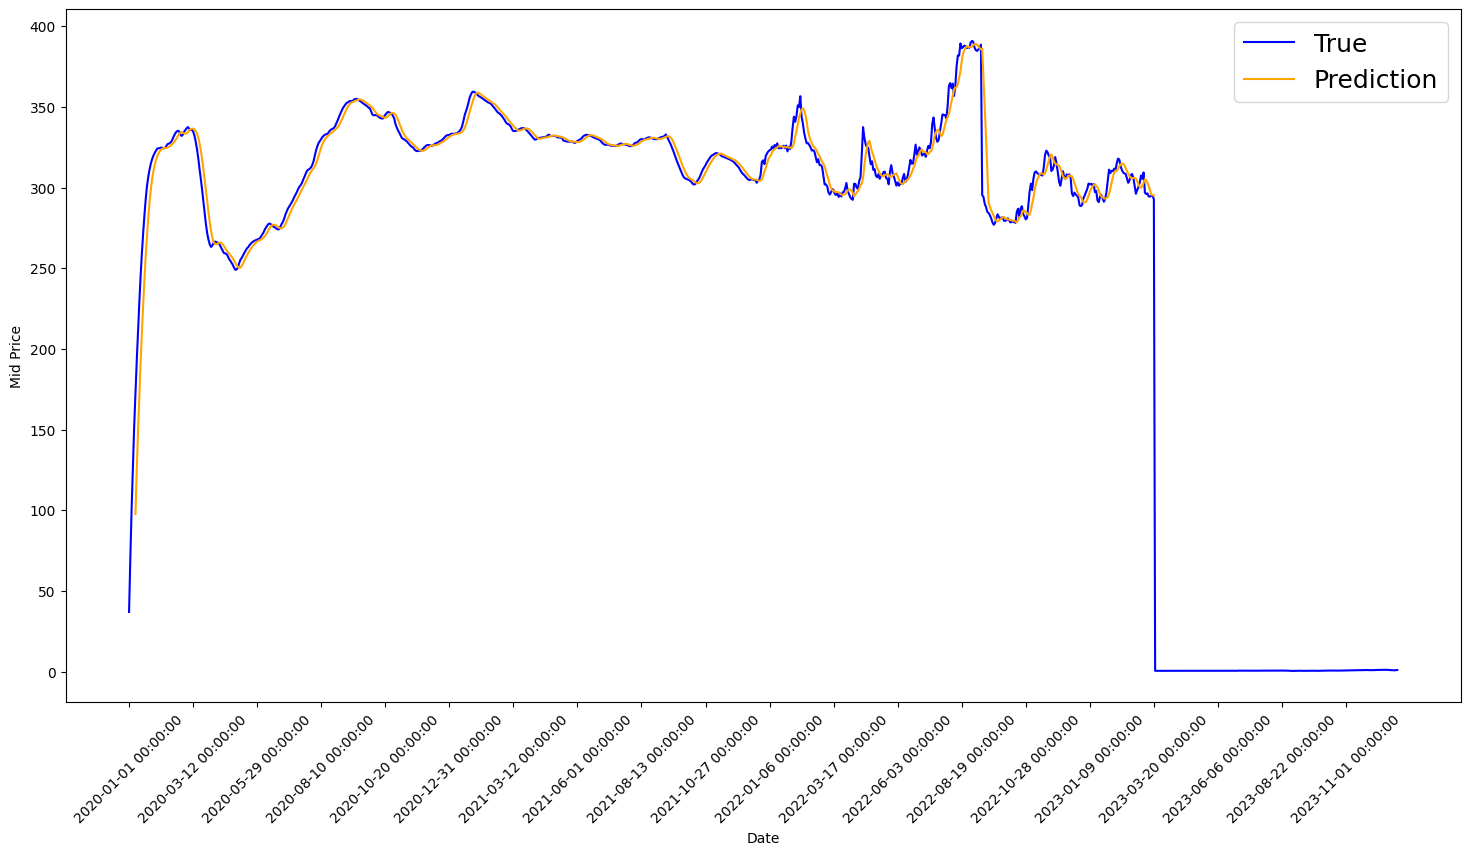

In [44]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

## Exponential Moving Average (EMA) Prediction

We implement an EMA prediction with a decay factor of 0.5.

We initialize a running_mean and iteratively update it using the EMA formula. The mean squared error (MSE) is calculated between the predictions and the actual training data.

In [45]:
window_size = 5
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 28.99845


Finally, we plot the actual mid-prices and the EMA predictions. This plot compares the EMA predictions with the actual mid-prices over time.

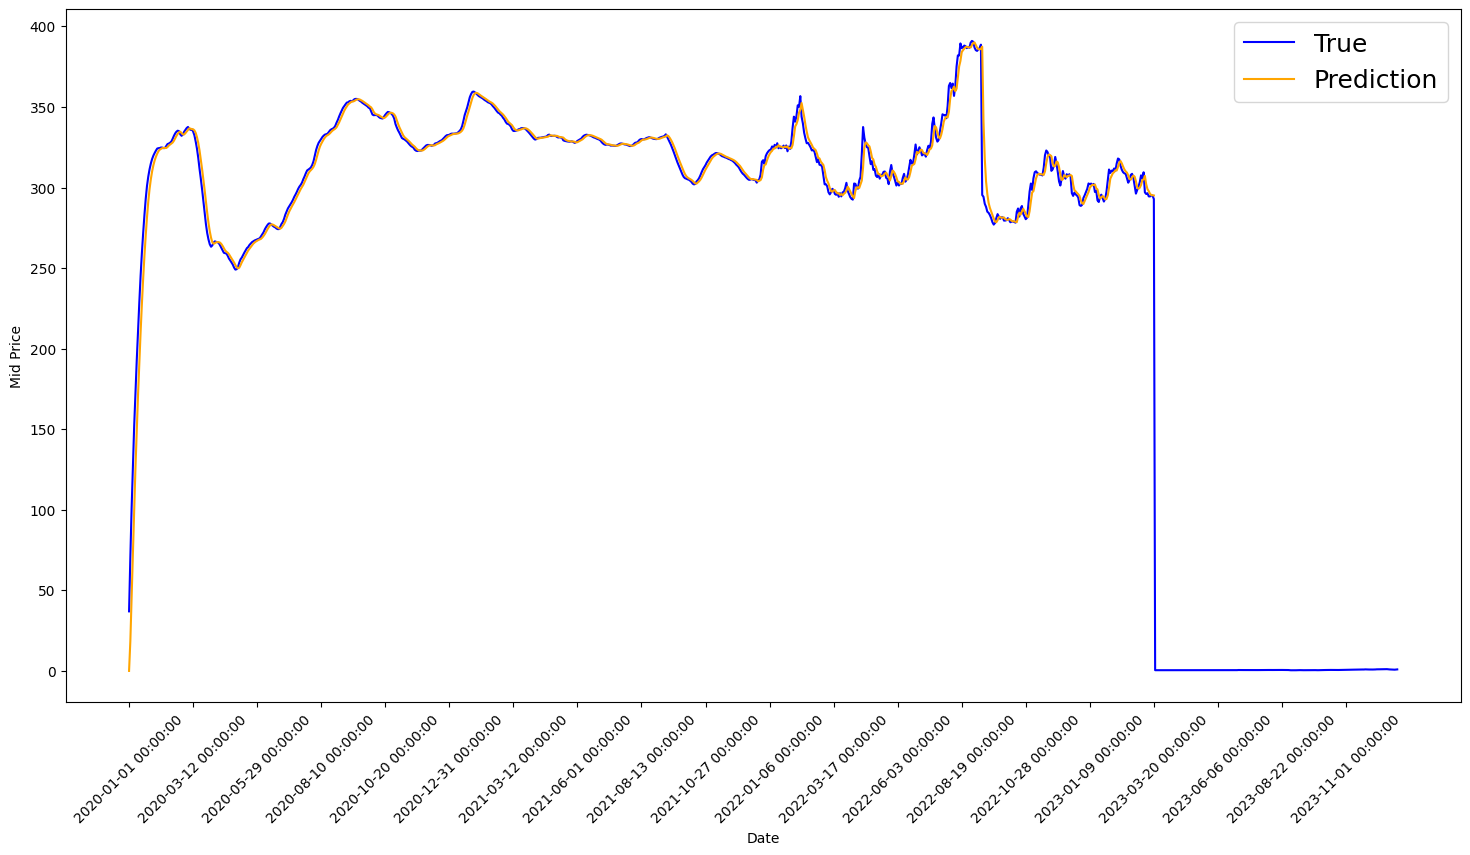

In [46]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

## Preparing Data for LSTM Model

We prepare the data for an LSTM model by scaling it and creating sequences.

We define a function create_sequences to create input sequences and corresponding target values for the LSTM model. We set the sequence_length to 57, meaning the model will use the last 57 time steps to predict the next value.

Finally, we split the sequences into training and test sets, using 80% of the data for training and 20% for testing.

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming `mid_prices` contains your mid-price data
scaler = MinMaxScaler()

# Scale the data
scaled_data = scaler.fit_transform(mid_prices.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 57  # Use last 50 timesteps to predict the next value
X, y = create_sequences(scaled_data, sequence_length)

# Split into training and test sets
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

## Defining and Compiling the LSTM Model

We define a sequential LSTM model for time series prediction.

The model consists of three LSTM layers with 100, 100, and 50 units, respectively. The first two LSTM layers return sequences, while the last one does not. Then, we add two dense layers with ReLU activation and a final dense layer with a single output neuron for regression.

We compile the model using the Adam optimizer and mean squared error loss function.

In [73]:
# Define the LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(100, return_sequences=True),
    LSTM(50, return_sequences=False),
    Dense(50, activation="relu"),
    Dense(25, activation="relu"),
    Dense(1)  # Output layer
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()


/opt/miniconda3/envs/coursera/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 57, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 57, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,251 (606.45 KB)

 Trainable params: 155,251 (606.45 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
from tensorflow.keras.callbacks import EarlyStopping

# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# , callbacks=[early_stopping]

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.2664 - val_loss: 0.0055
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0034 - val_loss: 0.0045
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step

## Making Predictions and Visualizing Results

We generate predictions using the trained LSTM model and visualize the results.

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


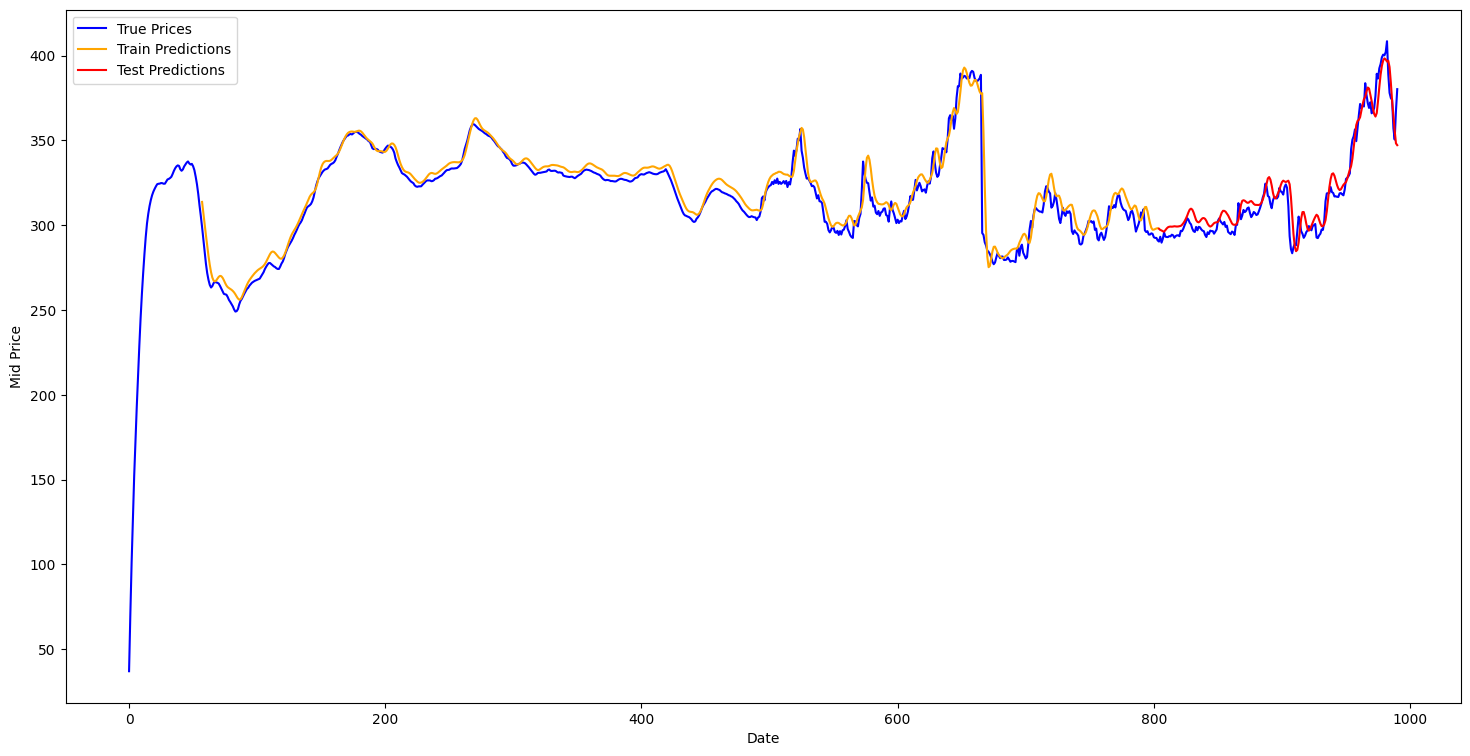

In [75]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Reverse scaling for comparison
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train)
y_test_actual = scaler.inverse_transform(y_test)

# Plot predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 9))
plt.plot(range(len(mid_prices)), scaler.inverse_transform(scaled_data), color='blue', label='True Prices')
plt.plot(range(sequence_length, sequence_length + len(train_predictions)), train_predictions, color='orange', label='Train Predictions')
plt.plot(range(sequence_length + len(train_predictions), len(mid_prices)), test_predictions, color='red', label='Test Predictions')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend()
plt.show()

## Predicting Future Stock Prices with New Data

We fetch new stock data and use the trained LSTM model to predict future prices.

We convert it to a pandas DataFrame, preprocess it by resetting the index, dropping the "Volume" column, and sorting by date. Then, we calculate the mid-prices.

In [76]:
# Fetch new stock data
new_data = stocks("APL", start=datetime.date(2024, 1, 1), end=datetime.date.today())

# Convert to a DataFrame
new_data_df = pd.DataFrame(new_data)

new_data_df = new_data_df.reset_index()
new_data_df = new_data_df.drop("Volume", axis=1)

# Sort DataFrame by date
new_data_df = new_data_df.sort_values('Date')

# Calculate mid prices
new_mid_prices = (new_data_df['High'] + new_data_df['Low']) / 2.0

# Convert to a NumPy array
new_mid_prices = new_mid_prices.to_numpy()

In [77]:
print(len(new_mid_prices))

280


Next, we scale the new mid-prices using the same scaler that was fitted on the training data. We then create input sequences using the create_sequences function, with a sequence length of 58 (one more than the previous training sequence length, to account for the first input to the new sequence). Finally, we use the trained LSTM model to make predictions and reverse the scaling to get the predictions in the original price scale.

In [78]:
new_mid_prices_scaled = scaler.transform(new_mid_prices.reshape(-1, 1))

X_new, _ = create_sequences(new_mid_prices_scaled, 58)

new_predictions = model.predict(X_new)
new_predictions = scaler.inverse_transform(new_predictions)  # Reverse scaling

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [79]:
print(len(X_new))

222


## Visualizing Predictions on New Data

We visualize the historical prices and the predictions made on the new data.

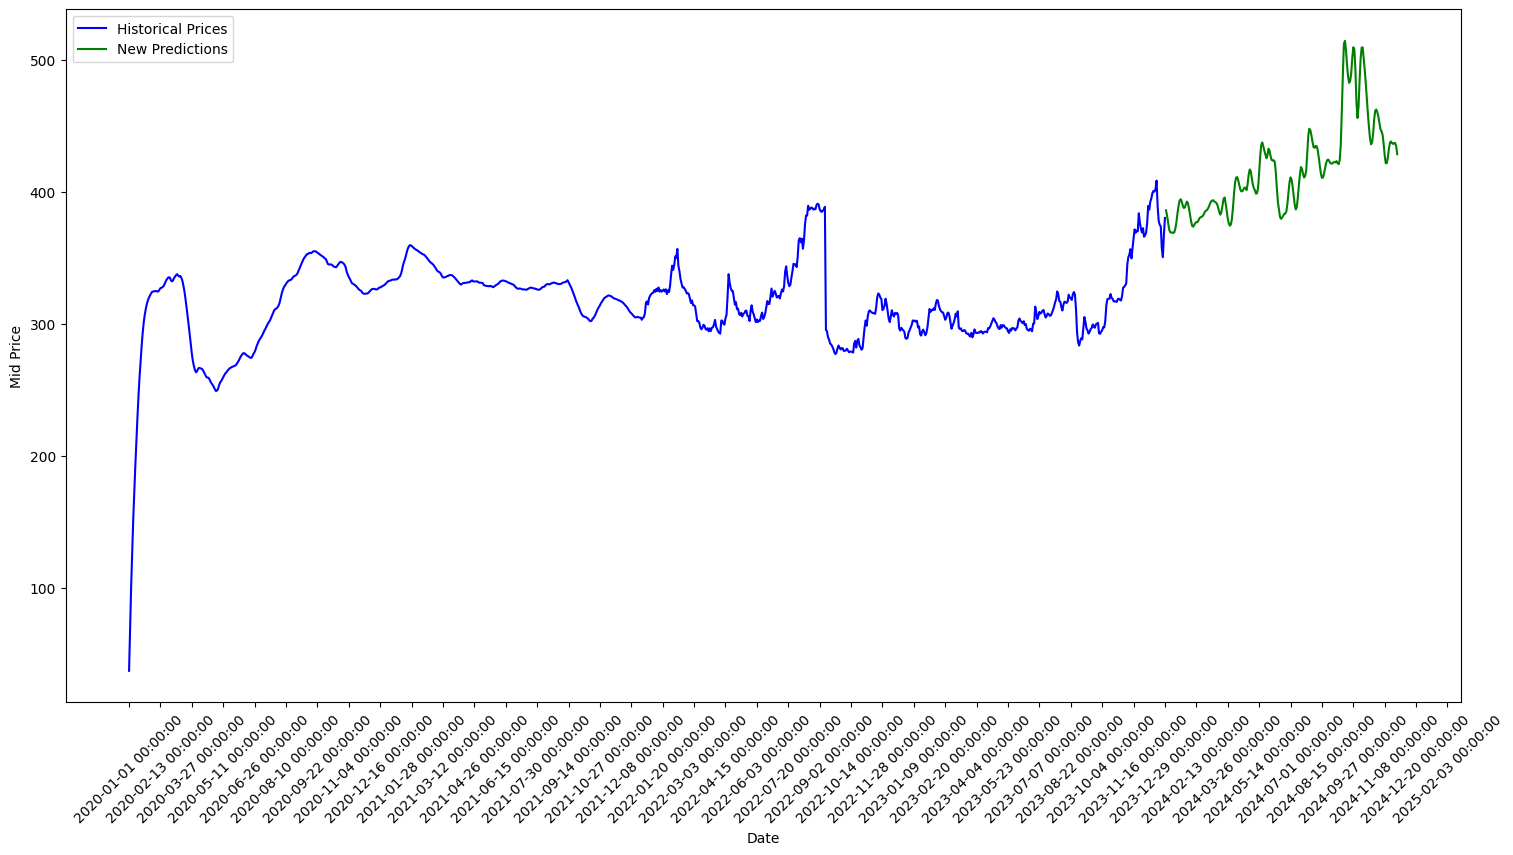

In [80]:
plt.figure(figsize=(18, 9))
plt.plot(range(len(mid_prices)), scaler.inverse_transform(scaled_data), color='blue', label='Historical Prices')
plt.plot(range(len(mid_prices), len(mid_prices) + len(new_predictions)), new_predictions, color='green', label='New Predictions')

# Combine the two columns into a single Series
combined_dates = pd.concat([df['Date'], new_data_df['Date']], ignore_index=True).sort_values().reset_index(drop=True)

# Space out x-ticks and use the combined dates
xtick_spacing = 30  # Adjust as needed
plt.xticks(
    ticks=range(0, len(combined_dates), xtick_spacing), 
    labels=combined_dates[::xtick_spacing], 
    rotation=45
)

plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend()
plt.show()


## Training History Visualization

We visualize the training history of the LSTM model, including training and validation loss, and optionally training and validation accuracy.

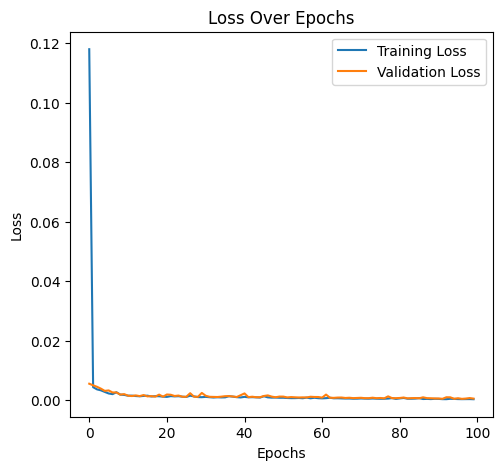

In [81]:
# Get training history
history_dict = history.history

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot accuracy (if available)
if 'accuracy' in history_dict:
    plt.subplot(1, 2, 2)
    plt.plot(history_dict['accuracy'], label='Training Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

plt.show()
